In [16]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

State of Data Collection

In [17]:

transform_mnist = transforms.Compose([
    transforms.ToTensor(),
])

transform_cifar = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transform_mnist)
#mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform_mnist)
cifar_train = datasets.CIFAR10(root='data', train=True, download=True, transform=transform_cifar)

#10k test setine ayrılıyor. olmazsa ConcatDataset ile birleştirilebilir. bu durumda train = False da yapılmalı
print(len(mnist_train), len(cifar_train))


60000 50000


Exploratory Data Analysis (EDA)

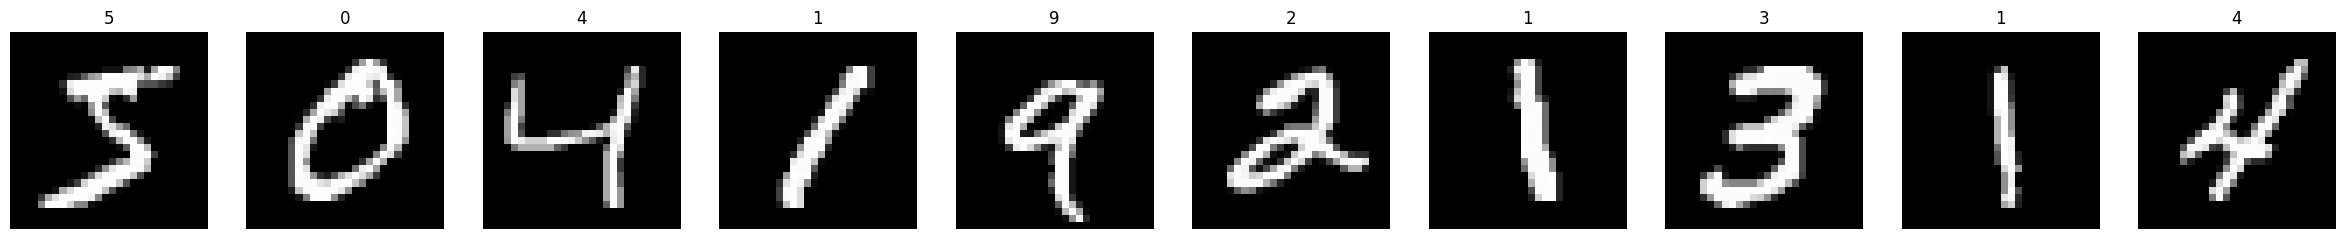

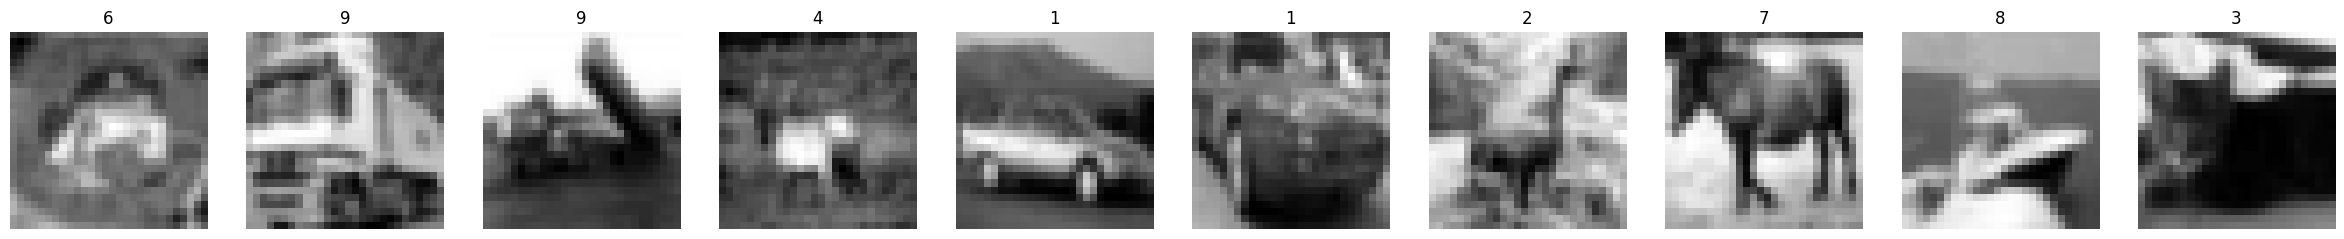

In [18]:
def show_samples(dataset, n=10):
    fig, axes = plt.subplots(1, n, figsize=(30, 15))
    for i in range(n):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

show_samples(mnist_train)
show_samples(cifar_train)

MNIST images are sparse and high-contrast, while preprocessed CIFAR-10 images are dense and textured.

Class Distribution

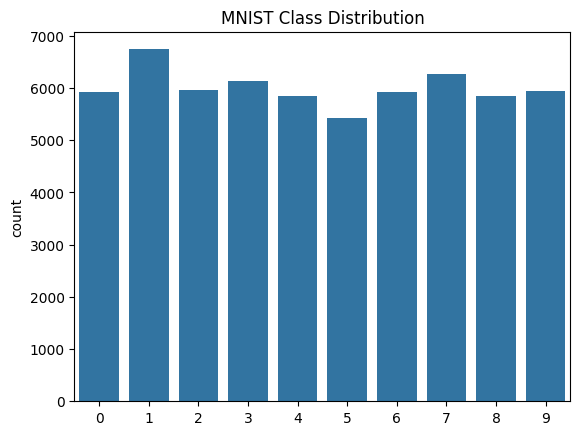

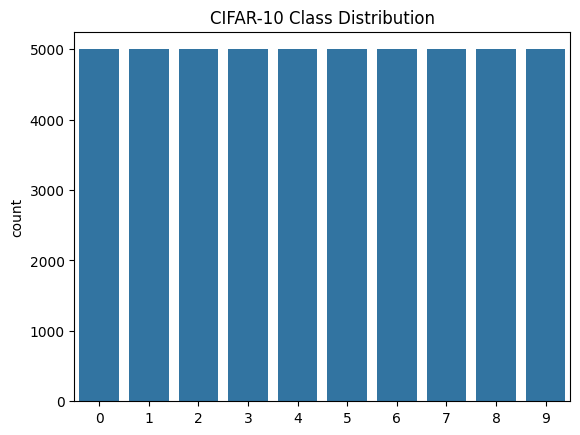

In [19]:
mnist_labels = [label for _, label in mnist_train]
cifar_labels = [label for _, label in cifar_train]

sns.countplot(x=mnist_labels)
plt.title("MNIST Class Distribution")
plt.show()

sns.countplot(x=cifar_labels)
plt.title("CIFAR-10 Class Distribution")
plt.show()

Both datasets are well-balanced across their 10 classes. Since there is not any class imbalance, the hardest part will be the domain seperation.

Pixel Statistics

In [20]:
#mean and standard deviation calculation
def dataset_stats(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1000)
    mean, std = 0, 0
    for images, _ in loader:
        mean += images.mean()
        std += images.std()
    mean /= len(loader)
    std /= len(loader)
    return mean.item(), std.item()

mnist_mean, mnist_std = dataset_stats(mnist_train)
cifar_mean, cifar_std = dataset_stats(cifar_train)
print("MNIST mean/std:", mnist_mean, mnist_std)
print("CIFAR mean/std:", cifar_mean, cifar_std)

MNIST mean/std: 0.13066047430038452 0.30800729990005493
CIFAR mean/std: 0.48107749223709106 0.23170432448387146


As we can see here, MNIST images are much darker (0.13 mean) and higher-contrast (0.30 std) than the preprocessed CIFAR-10 images (0.48 mean, 0.23 std).

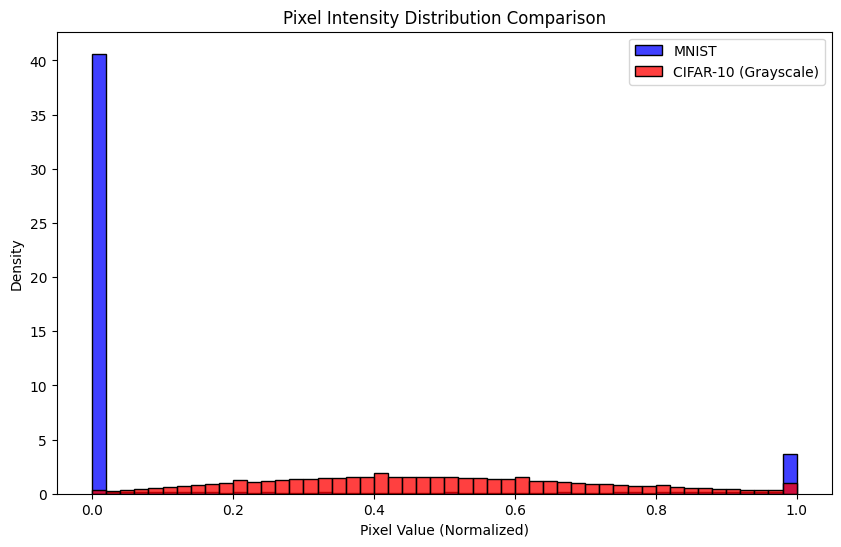

In [21]:
# Create histograms of pixel values
mnist_pixels = np.array([img.numpy().flatten() for img, _ in mnist_train])
cifar_pixels = np.array([img.numpy().flatten() for img, _ in cifar_train])

plt.figure(figsize=(10, 6))
sns.histplot(mnist_pixels.flatten(), color='blue', label='MNIST', stat='density', bins=50)
sns.histplot(cifar_pixels.flatten(), color='red', label='CIFAR-10 (Grayscale)', stat='density', bins=50)
plt.title('Pixel Intensity Distribution Comparison')
plt.xlabel('Pixel Value (Normalized)')
plt.legend()
plt.show()

We can see here as well, MNIST has high contrast (gathered around 0/black and 1/white) and CIFAR-10 hass less contrast, having mostly gray tones.

In [22]:
#flattening of images for PCA and t-SNE
def flatten_images(dataset, n=500):
    imgs, labels = [], []
    for i in range(n):
        img, label = dataset[i]
        imgs.append(img.view(-1).numpy())
        labels.append(label)
    return np.array(imgs), np.array(labels)

mnist_imgs, mnist_labels = flatten_images(mnist_train)
cifar_imgs, cifar_labels = flatten_images(cifar_train)

combined_imgs = np.concatenate([mnist_imgs, cifar_imgs])
combined_labels = np.concatenate([["MNIST"]*len(mnist_labels), ["CIFAR"]*len(cifar_labels)])

PCA Projection

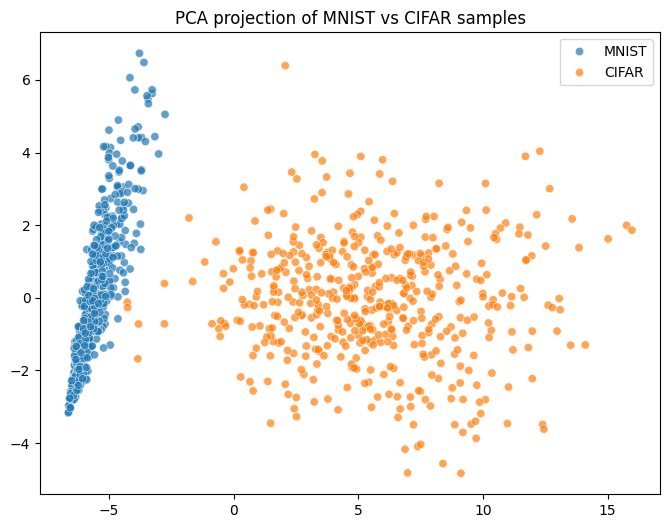

In [23]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(combined_imgs)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=combined_labels, alpha=0.7)
plt.title("PCA projection of MNIST vs CIFAR samples")
plt.show()

T-SNE Visualization

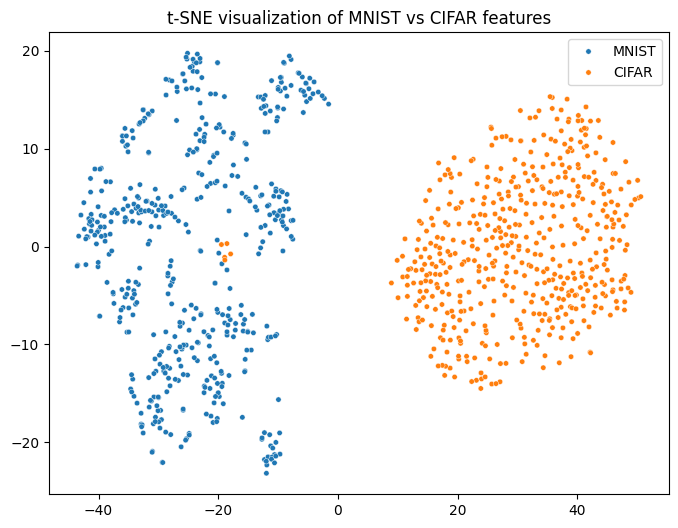

In [24]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(combined_imgs)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=combined_labels, palette='tab10', s=15)
plt.title("t-SNE visualization of MNIST vs CIFAR features")
plt.show()

Both PCA and t-SNE visualization shows that MNIST and CIFAR10 is a clearly two distinct domains, which will be rather easy for our model to distinguish between.

Domain Difference Measure

In [25]:
from scipy.stats import entropy

def image_entropy(img):
    hist, _ = np.histogram(img.numpy().flatten(), bins=256, range=(0,1))
    hist = hist / np.sum(hist)
    return entropy(hist)

print("MNIST image entropy (avg):", np.mean([image_entropy(mnist_train[i][0]) for i in range(1000)]))
print("CIFAR10 image entropy (avg):", np.mean([image_entropy(cifar_train[i][0]) for i in range(1000)]))


MNIST image entropy (avg): 1.1138957505079998
CIFAR10 image entropy (avg): 4.77149388776275


It shows us that MNIST images are simple and predictable while CIFAR-10 images are complex and noisy.

Domain Difference Prediction with K-Means Clustering

Adjusted Rand Score (k=2 vs. Domains): 0.9177
(A score close to 1.0 means k-means successfully found the two domains)


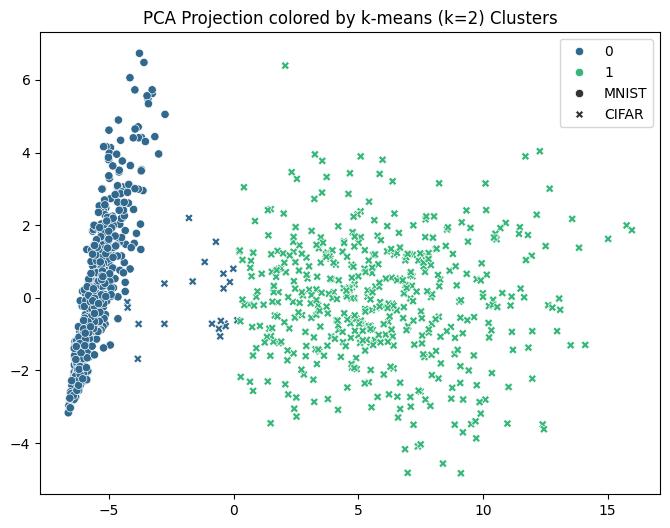

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# 2 clusters for two domains
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(combined_imgs)

domain_numeric_labels = [0 if label == "MNIST" else 1 for label in combined_labels]
score = adjusted_rand_score(domain_numeric_labels, cluster_labels)
print(f"Adjusted Rand Score (k=2 vs. Domains): {score:.4f}")
print("(A score close to 1.0 means k-means successfully found the two domains)")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=cluster_labels, style=combined_labels, palette='viridis')
plt.title("PCA Projection colored by k-means (k=2) Clusters")
plt.show()

It is demonstrated here that even without labels the model would be able to tell apart these two domains. 

Analysis of Domain Difference on Same Class

Number of MNIST '0' images: 5923
Number of CIFAR-10 '0' images: 5000
--- MNIST Class 0 (Digit '0') ---


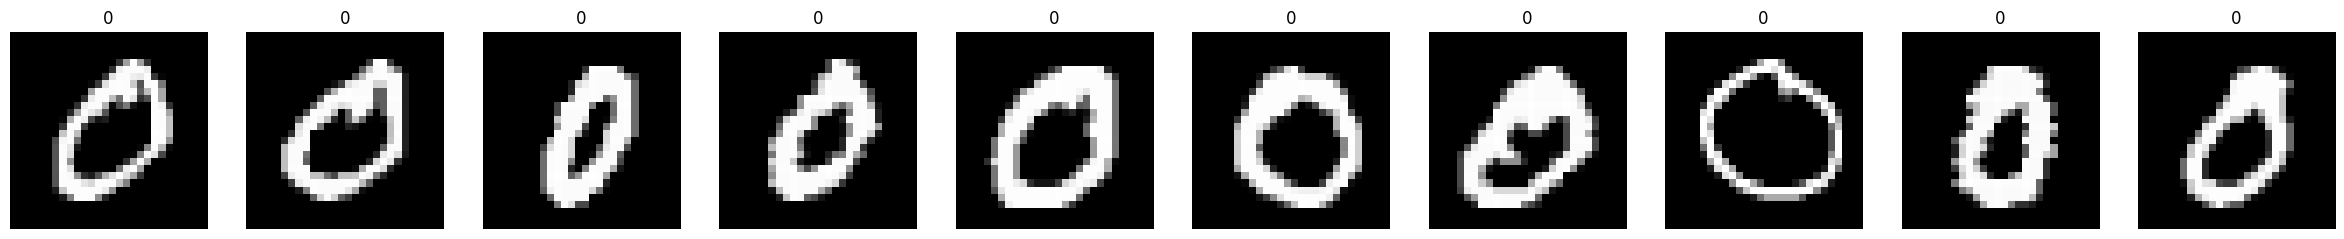

--- CIFAR-10 Class 0 (Airplane) ---


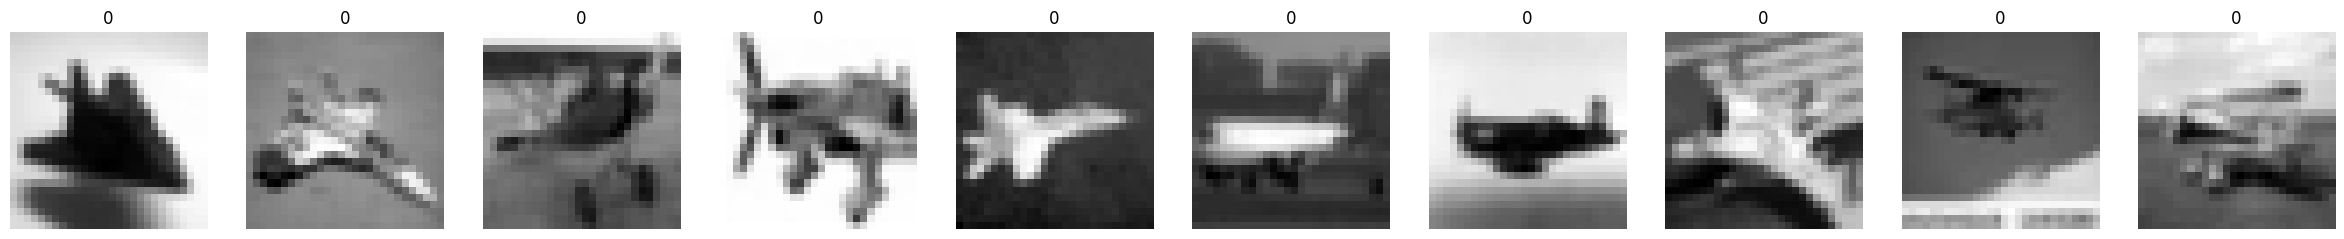

In [27]:
mnist_class_0_data = [data for data in mnist_train if data[1] == 0]

cifar_class_0_data = [data for data in cifar_train if data[1] == 0]

print(f"Number of MNIST '0' images: {len(mnist_class_0_data)}")
print(f"Number of CIFAR-10 '0' images: {len(cifar_class_0_data)}")

print("--- MNIST Class 0 (Digit '0') ---")
show_samples(mnist_class_0_data, n=10)

print("--- CIFAR-10 Class 0 (Airplane) ---")
show_samples(cifar_class_0_data, n=10)

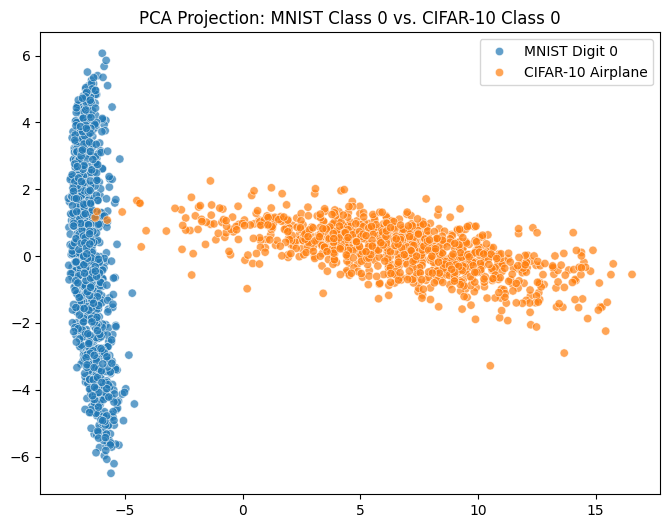

In [28]:
n_samples = 1000
mnist_0_imgs = np.array([img.numpy().flatten() for img, _ in mnist_class_0_data[:n_samples]])
cifar_0_imgs = np.array([img.numpy().flatten() for img, _ in cifar_class_0_data[:n_samples]])

combined_class_0_imgs = np.concatenate([mnist_0_imgs, cifar_0_imgs])
combined_class_0_labels = np.concatenate([
    ["MNIST Digit 0"] * len(mnist_0_imgs),
    ["CIFAR-10 Airplane"] * len(cifar_0_imgs)
])

pca_class_0 = PCA(n_components=2)
reduced_class_0 = pca_class_0.fit_transform(combined_class_0_imgs)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=reduced_class_0[:, 0],
    y=reduced_class_0[:, 1],
    hue=combined_class_0_labels,
    alpha=0.7
)
plt.title("PCA Projection: MNIST Class 0 vs. CIFAR-10 Class 0")
plt.show()

The goal here was to observe the possible distinction between the overlapping classes of each domain. As we see here, even though both classes are classified as 0, they are too different (two distinct groups) and rather easy to differantiate for a model.